# Anomaly Detection in High Dimensions Using Auto-encoder
Anomaly detection detects data points (outliers) which do not conform to an expected pattern or other items in a dataset. In statistics, anomalies, also known as outliers, are observation points that are distant from other observations. An outlier may be due to variability in the measurement or it may indicate experimental error, and it can cause serious problems in statistical analyses. In this notebook we demonstrate how to do unsupervised anomaly detection in high dimensions using auto-encoder.

We are using one of the HiCS realworld data sets ([link](https://www.ipd.kit.edu/~muellere/HiCS)) for demo. The data set contains 32 dimensions and 351 instances, with 126 of them being outliers. Alternative datasets are in the same directory, however, typically datasets with higher dimension and lower outlier proportion will have a better performance. Data points with higher reconstruction error are more likely to be outliers, and this notebook can also show which dimensions the points are outlying.

References:
* [Neural-based Outlier Discovery](https://edouardfouche.com/Neural-based-Outlier-Discovery)

## Initialization
* import necesary libraries and load data

In [1]:
from zoo.common.nncontext import *
sc = init_nncontext("Anomaly Detection HD Example")

from scipy.io import arff
import pandas as pd

from zoo.pipeline.api.keras.layers import Input, Dense
from zoo.pipeline.api.keras.models import Model

dataset = "ionosphere"           #real world dataset

import os
data_dir = os.getenv("ANALYTICS_ZOO_HOME")+"/bin/data/HiCS/"+dataset+".arff"

epoch = 2500

rawdata, _ = arff.loadarff(data_dir)
data = pd.DataFrame(rawdata)

## Data preprocessing
*  save the label and delete them from the original data set

In [2]:
labels = data['class'].astype(int)
del data['class']

labels[labels != 0] = 1

* MinMaxScaler is used since we need to keep the features of outliers

In [3]:
from sklearn.preprocessing import MinMaxScaler
data_norm = MinMaxScaler().fit_transform(data).astype('float32')

In [4]:
print("Instances: %d \nOutliers: %d\nAttributes: %d" % (len(data), sum(labels), len(data_norm[0])))

Instances: 351 
Outliers: 126
Attributes: 32


## Build the model

In [5]:
compress_rate=0.8
origin_dim=len(data_norm[0])

input = Input(shape=(origin_dim,))
encode = Dense(int(compress_rate*origin_dim), activation='relu')(input)
decode = Dense(origin_dim, activation='sigmoid')(encode)

autoencoder = Model(input, decode)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel
creating: createAdadelta
creating: createZooKerasBinaryCrossEntropy


## Training

In [6]:
autoencoder.fit(x=data_norm,
                y=data_norm,
                batch_size=100,
                nb_epoch=epoch,
                validation_data=None)

## Prediction
* data are encoded and reconstructed

In [7]:
data_trans = autoencoder.predict(data_norm).collect()

## Evaluation
* calculate the euclidean distance from each point to its reconstruction

In [8]:
import numpy as np
dist = []
for i, x in enumerate(data_norm):
    dist.append(np.linalg.norm(data_norm[i] - data_trans[i]))
dist=np.array(dist)

* plot the ROC curve to assess the quality of detection

AUC = 0.941975


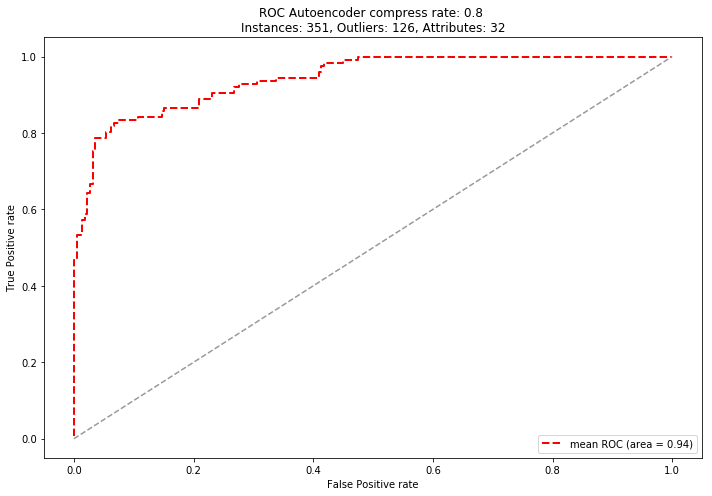

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, threshold = roc_curve(labels, dist)
roc_auc = auc(fpr, tpr)
print('AUC = %f' % roc_auc)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, 'k--',
         label='mean ROC (area = %0.2f)' % roc_auc, lw=2, color='red')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6))
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Autoencoder compress rate: %0.1f ' % compress_rate + "\nInstances: %d, Outliers: %d, Attributes: %d" % (len(data), sum(labels), len(data_norm[0])))
plt.legend(loc="lower right")
plt.tight_layout()
#plt.savefig("./fig/"+dataset+".ROC.png")

plt.show()

* plot the outlier scores of each single data point

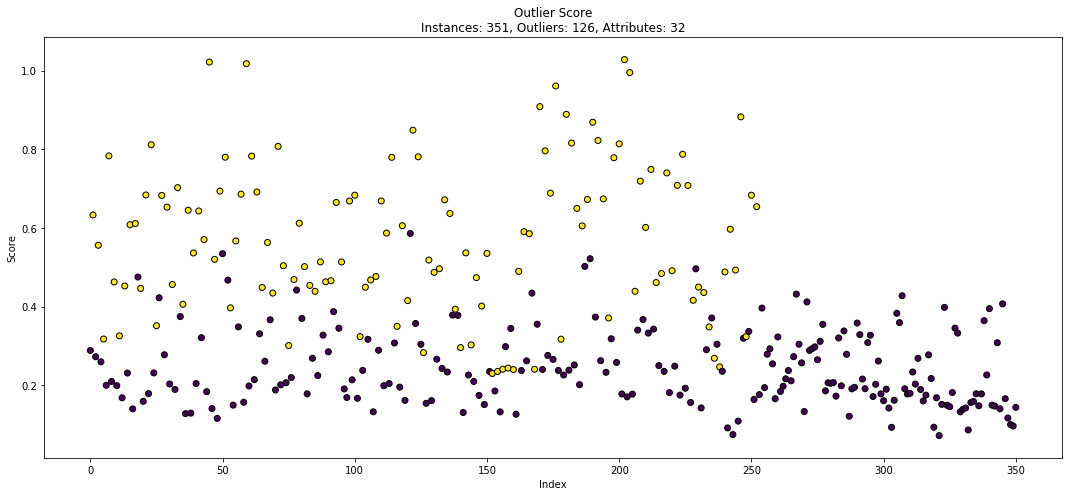

In [11]:
plt.figure(figsize=(15, 7))
plt.scatter(data.index, dist, c=labels, edgecolors="black")
plt.xlabel('Index')
plt.ylabel('Score')
plt.title("Outlier Score\nInstances: %d, Outliers: %d, Attributes: %d" % (len(data), sum(labels), len(data_norm[0])))
plt.tight_layout()
#plt.savefig("./fig/"+dataset+".score.png")
plt.show()

* show top 20 data points with highest outlier score in descending order

In [12]:
print(np.argsort(-dist)[0:20])

[202  45  59 204 176 170 180 246 190 122 192 182 200  23  71 172 224   7
  61 124]


* plot the reconstruction error in dimension of one point (here take point 202 as an example)

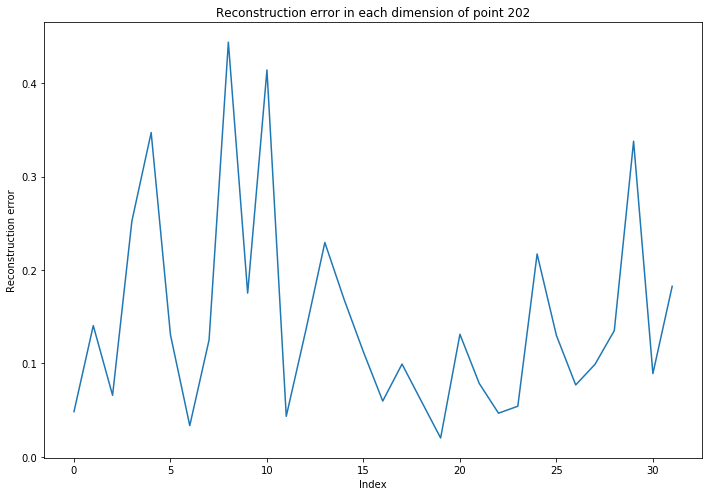

In [113]:
def error_in_dim(index):
    error = []
    for i, x in enumerate(data_norm[index]):
        error.append(abs(data_norm[index][i] - data_trans[index][i]))
    error=np.array(error)
    return error

example = 202

plt.figure(figsize=(10,7))
plt.plot(error_in_dim(example))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point %d" % example)
plt.tight_layout()
plt.show()

* show top 3 dimensions with highest reconstruction error in descending order

In [114]:
print(np.argsort(-error_in_dim(example))[0:3])

[ 8 10  4]


* Look at the position of the point in a subspace [6,7,8]

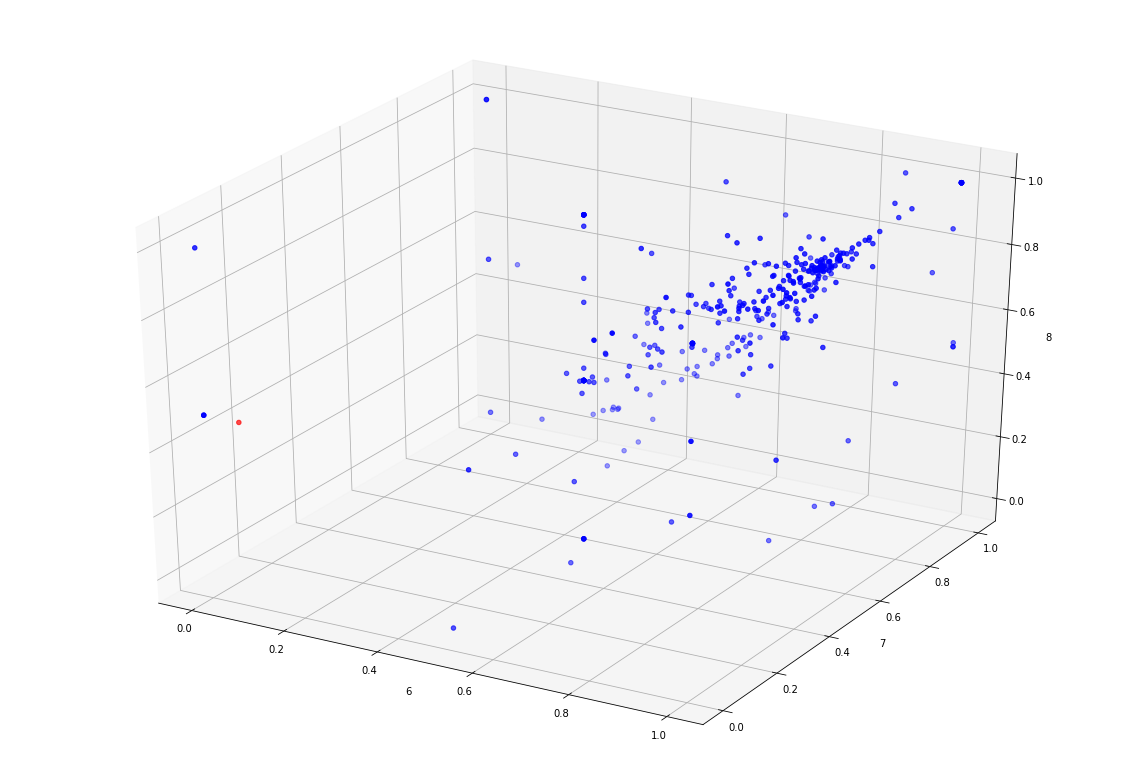

In [119]:
indicator = ['b']*len(data)
indicator[example] = 'r'
indicator=pd.Series(indicator)

from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure(figsize=(20,14)).gca(projection='3d')
threedee.scatter(data['var_0006'], data['var_0007'], zs=data['var_0008'], 
                 c=indicator)
threedee.set_xlabel('6')
threedee.set_ylabel('7')
threedee.set_zlabel('8')
plt.show()

* Look at the Reconstruction errors of outliers in a certain subspace

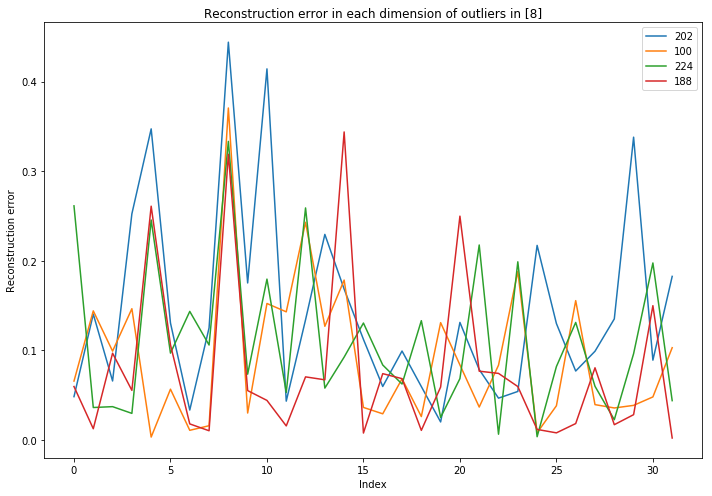

In [120]:
plt.figure(figsize=(10,7))
outliers = [202, 100, 224, 188]
for i in outliers:
    plt.plot(error_in_dim(i), label=i)
plt.legend(loc=1)
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of outliers in [8]")
plt.tight_layout()
plt.show()

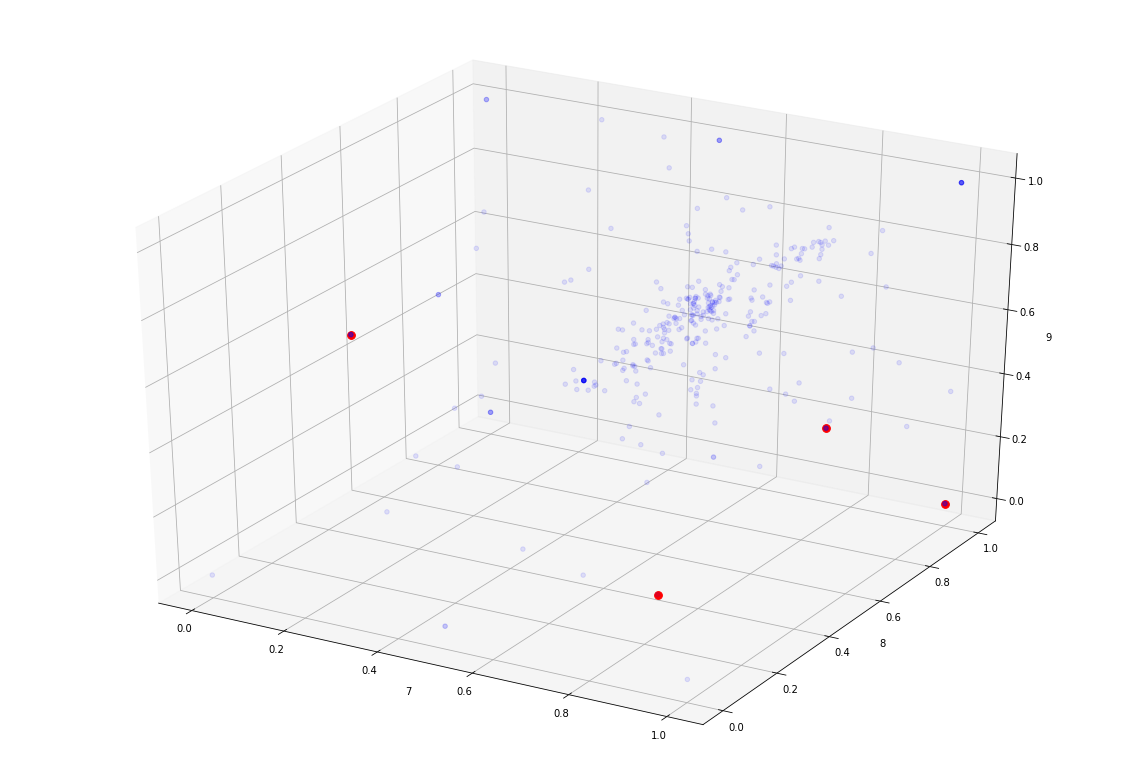

In [121]:
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure(figsize=(20,14)).gca(projection='3d')

threedee.scatter(data['var_0007'], data['var_0008'], zs=data['var_0009'], c='b', alpha=0.1)

for i in outliers:
    threedee.scatter(data['var_0007'][i], data['var_0008'][i], zs=data['var_0009'][i], c="r", s=60)
    #print(data['var_0007'][i], data['var_0008'][i], data['var_0009'][i])

threedee.set_xlabel('7')
threedee.set_ylabel('8')
threedee.set_zlabel('9')
plt.show()